In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# from tensorboardX import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [81]:
fpath = "../../data/DNN_data/v1/"

sig_with_artifact = np.load(fpath + "data_signal_with_sine_regular_pattern" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


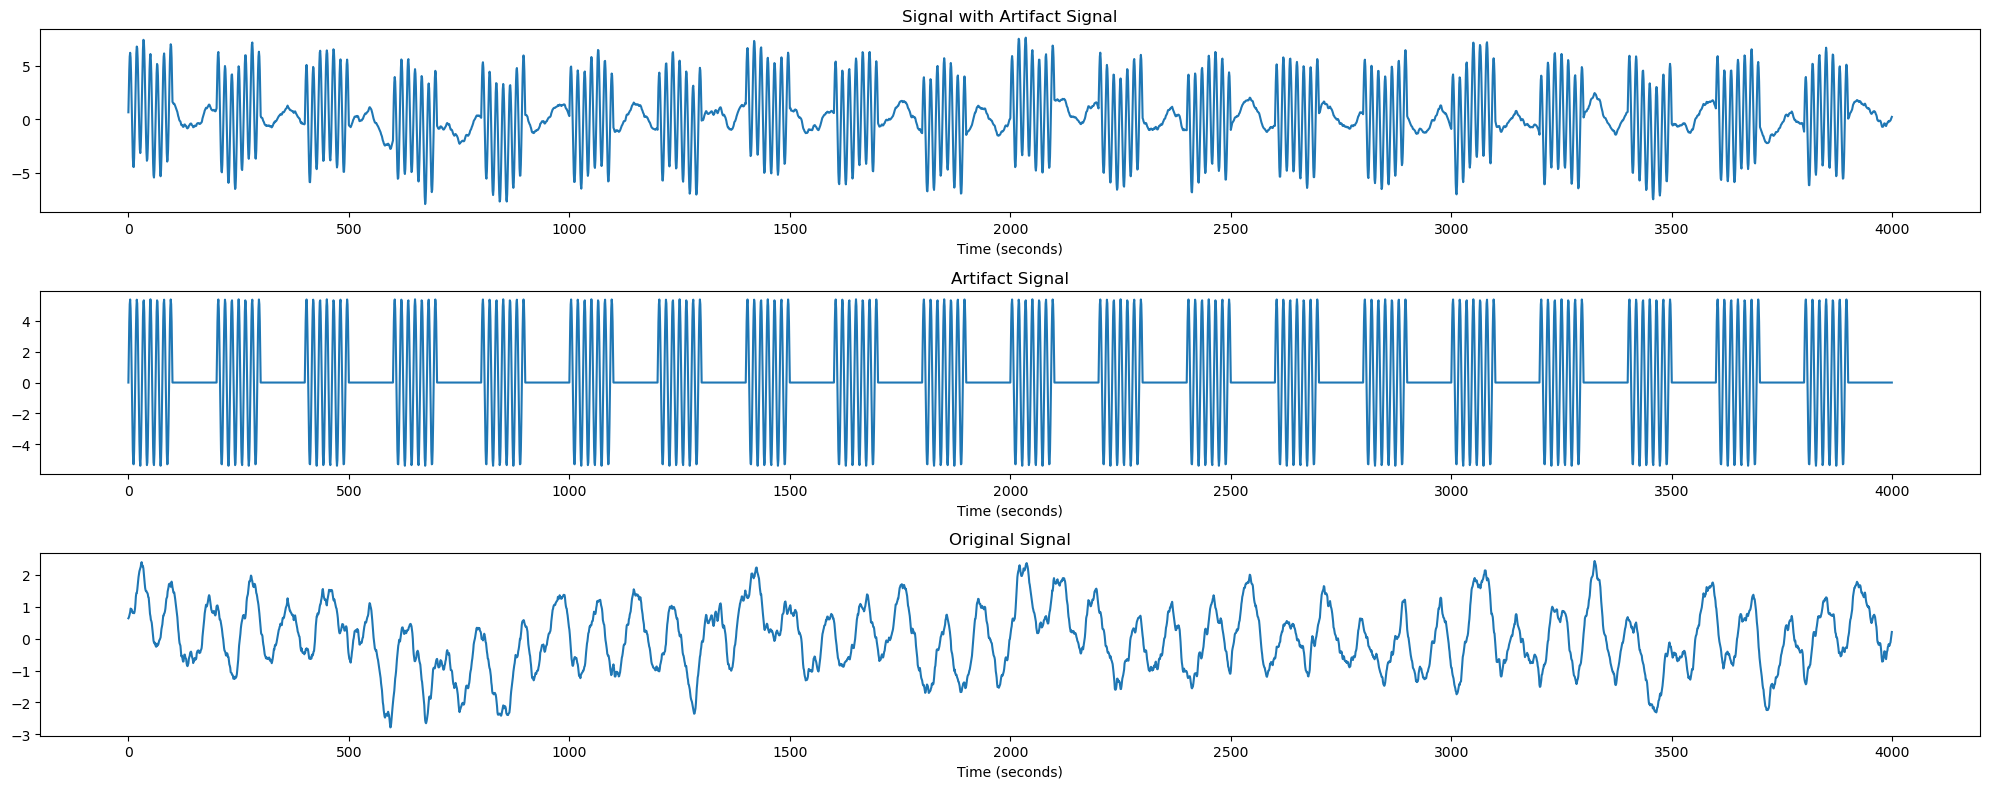

In [82]:
plt.figure(figsize=(20,8))

plt.subplot(3, 1, 1)
plt.plot(sig_with_artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(sig[0])
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

plt.tight_layout()

In [83]:
sig_with_artifact = sig_with_artifact.transpose()
sig = sig.transpose()

print(sig_with_artifact.shape)
print(sig.shape)

(4000, 1000)
(4000, 1000)


(1000, 4000)
(1000, 4000)


(-3.0, 3.0)

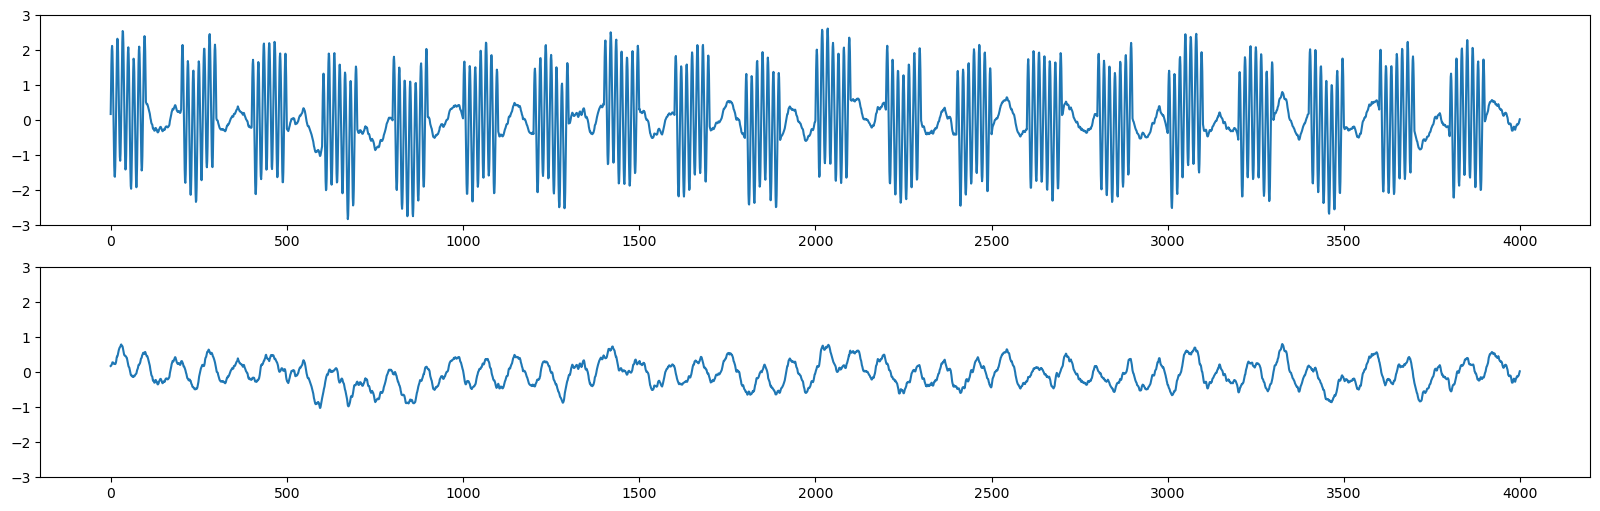

In [84]:
# StandardScaler를 이용하여 정규화
scaler = StandardScaler()
X = scaler.fit_transform(sig_with_artifact)
# y = scaler.fit_transform(sig)
y = (sig-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

X = X.transpose()
y = y.transpose()

print(X.shape)
print(y.shape)

plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)
plt.plot(X[0])
plt.ylim([-3, 3])
plt.subplot(2, 1, 2)
plt.plot(y[0])
plt.ylim([-3, 3])

In [85]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("-----------------------------")
print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("-----------------------------")
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))
print("-----------------------------")

X_train = X_train.reshape(X_train.shape[0], 4000, 1)
X_test = X_test.reshape(X_test.shape[0], 4000, 1)

print("<unsqueezed>")
print("-----------------------------")
print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x T, y : B x T
print("-----------------------------")
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)

-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<unsqueezed>
-----------------------------
X_train shape: (800, 4000, 1)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000, 1)
y_test shape: (200, 4000)
-----------------------------


In [86]:
# 인코더 네트워크 생성

class Encoder(nn.Module):    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)        
        self.training = True
        
    def forward(self, x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)                           
        return mean, log_var # 인코더 네트워크에서 평균과 분산을 반환

In [87]:
# 디코더 네트워크

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))        
        # x_hat = torch.sigmoid(self.output(h)) # 디코더 결과는 시그모이드를 통과했으므로 0~1 값을 가짐
        x_hat = self.output(h)
        return x_hat 

In [88]:
# VAE 네트워크

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var): # 평균과 표준편차를 통해 latent vector z를 샘플링
        epsilon = torch.randn_like(var).to(device)                
        z = mean + var*epsilon # z 값 구하기   
        return z
                        
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.Decoder(z)        
        return x_hat, mean, log_var, z # 디코더 결과와 평균, 표준편차를 반환

In [89]:
# 인코더와 디코더 객체 초기화

x_dim  = 4000
hidden_dim = 400
latent_dim = 40
epochs = 100
batch_size = 50

encoder_X = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder_X = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

encoder_y = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder_y = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model_X = Model(Encoder=encoder_X, Decoder=decoder_X).to(device)
model_y = Model(Encoder=encoder_y, Decoder=decoder_y).to(device)

In [90]:
# 손실 함수 정의

def loss_function(x, x_hat, mean, log_var): # 오차 구하는 함수, KLD를 계산하고 KLD가 줄어드는 방향으로 q(z)를 업데이트
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') # Loss Function을 BCE에서 MSE로 변경
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

optimizer_X = torch.optim.Adam(model_X.parameters(), lr=1e-3)
optimizer_y = torch.optim.Adam(model_y.parameters(), lr=1e-3)

In [91]:
# 모델 Train 함수 정의 X -> X

# saved_loc = 'scalar/' # 텐서보드에서 사용할 경로
# import os
# import shutil
# if os.path.exists('scalar/'):
#     # 폴더가 존재하면 폴더 내의 모든 내용을 삭제
#     shutil.rmtree('scalar/')

# writer = SummaryWriter(saved_loc) # 텐서보드: 오차와 같은 주요 측정 항목들이 학습 과정에서 어떻게 변하는지 알고자 할 때 사용

model_X.train()
def train_X(epoch, model, train_loader, optimizer):
    train_loss = 0
    for _, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var, z = model(x)
        MSE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = MSE + KLD
        # add_scalar: 텐서보드에 오차 등 주요 측정 항목의 결과를 출력할 때 사용
        # writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) ) 
        # writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        # writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        
        train_loss += loss.item()  
        loss.backward()
        optimizer.step()
          
        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {}\t Loss: {:.6f}'.format(
        #         epoch, loss.item() / len(y)))
    if epoch == 0:
        print(f"Epoch: [{epoch}/{epochs}]\t\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')
    elif epoch%10==0:        
        print(f"Epoch: [{epoch}/{epochs}]\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')

In [92]:
# 모델 Test 함수 정의 X

def test_X(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)   
            x_hat, mean, log_var, z = model(x)
            MSE, KLD = loss_function(x, x_hat, mean, log_var)
            loss = MSE + KLD

            # 테스트 데이터셋에 대해서도 오차를 로그에 저장
            # writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/Total Loss" , loss.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            test_loss += loss.item()

            # if batch_idx == 0:
            #     n = min(x.size(0), 8)
            #     comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
            #     grid = torchvision.utils.make_grid(comparison.cpu()) 
            #     writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)
        if epoch == 0:
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")
        elif epoch%10==0:        
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")

In [93]:
# 모델 Train 함수 정의 y -> y

# saved_loc = 'scalar/' # 텐서보드에서 사용할 경로
# import os
# import shutil
# if os.path.exists('scalar/'):
#     # 폴더가 존재하면 폴더 내의 모든 내용을 삭제
#     shutil.rmtree('scalar/')

# writer = SummaryWriter(saved_loc) # 텐서보드: 오차와 같은 주요 측정 항목들이 학습 과정에서 어떻게 변하는지 알고자 할 때 사용

model_y.train()
def train_y(epoch, model, train_loader, optimizer):
    train_loss = 0
    for batch_idx, (_, y) in enumerate(train_loader):
        y = y.view(batch_size, x_dim)
        y = y.to(device)
        optimizer.zero_grad()
        y_hat, mean, log_var, z = model(y)
        MSE, KLD = loss_function(y, y_hat, mean, log_var)
        loss = MSE + KLD
        # add_scalar: 텐서보드에 오차 등 주요 측정 항목의 결과를 출력할 때 사용
        # writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) ) 
        # writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        # writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        
        train_loss += loss.item()  
        loss.backward()
        optimizer.step()
          
        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {}\t Loss: {:.6f}'.format(
        #         epoch, loss.item() / len(y)))
    if epoch == 0:
        print(f"Epoch: [{epoch}/{epochs}]\t\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')
    elif epoch%10==0:        
        print(f"Epoch: [{epoch}/{epochs}]\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')

In [94]:
# 모델 Test 함수 정의 y

def test_y(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (_, y) in enumerate(test_loader):
            y = y.view(batch_size, x_dim)
            y = y.to(device)   
            y_hat, mean, log_var, z = model(y)
            MSE, KLD = loss_function(y, y_hat, mean, log_var)
            loss = MSE + KLD

            # 테스트 데이터셋에 대해서도 오차를 로그에 저장
            # writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/Total Loss" , loss.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            test_loss += loss.item()

            # if batch_idx == 0:
            #     n = min(x.size(0), 8)
            #     comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
            #     grid = torchvision.utils.make_grid(comparison.cpu()) 
            #     writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)
        if epoch == 0:
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")
        elif epoch%10==0:        
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")

In [95]:
# 모델 학습 X

from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
    train_X(epoch, model_X, train_loader, optimizer_X)
    test_X(epoch, model_X, test_loader)
# writer.close()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: [0/100]		Train Loss: 1385.0269	Test Loss: 429.0462
Epoch: [10/100]	Train Loss: 272.5818	Test Loss: 274.6648
Epoch: [20/100]	Train Loss: 265.6272	Test Loss: 264.2053
Epoch: [30/100]	Train Loss: 259.3005	Test Loss: 260.7611
Epoch: [40/100]	Train Loss: 248.1198	Test Loss: 250.5081
Epoch: [50/100]	Train Loss: 239.5629	Test Loss: 244.4144
Epoch: [60/100]	Train Loss: 230.4043	Test Loss: 239.7649
Epoch: [70/100]	Train Loss: 219.6921	Test Loss: 231.0272
Epoch: [80/100]	Train Loss: 209.4374	Test Loss: 223.4184
Epoch: [90/100]	Train Loss: 199.4350	Test Loss: 218.8815


In [96]:
# 모델 학습 y

from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
    train_y(epoch, model_y, train_loader, optimizer_y)
    test_y(epoch, model_y, test_loader)
# writer.close()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: [0/100]		Train Loss: 330.7472	Test Loss: 264.8563
Epoch: [10/100]	Train Loss: 236.1949	Test Loss: 240.8822
Epoch: [20/100]	Train Loss: 209.6083	Test Loss: 220.5721
Epoch: [30/100]	Train Loss: 185.5088	Test Loss: 205.2049
Epoch: [40/100]	Train Loss: 166.3204	Test Loss: 198.1903
Epoch: [50/100]	Train Loss: 150.0957	Test Loss: 198.4223
Epoch: [60/100]	Train Loss: 137.9139	Test Loss: 201.8889
Epoch: [70/100]	Train Loss: 127.9026	Test Loss: 204.9650
Epoch: [80/100]	Train Loss: 119.7260	Test Loss: 210.8295
Epoch: [90/100]	Train Loss: 113.7531	Test Loss: 213.3832


No handles with labels found to put in legend.


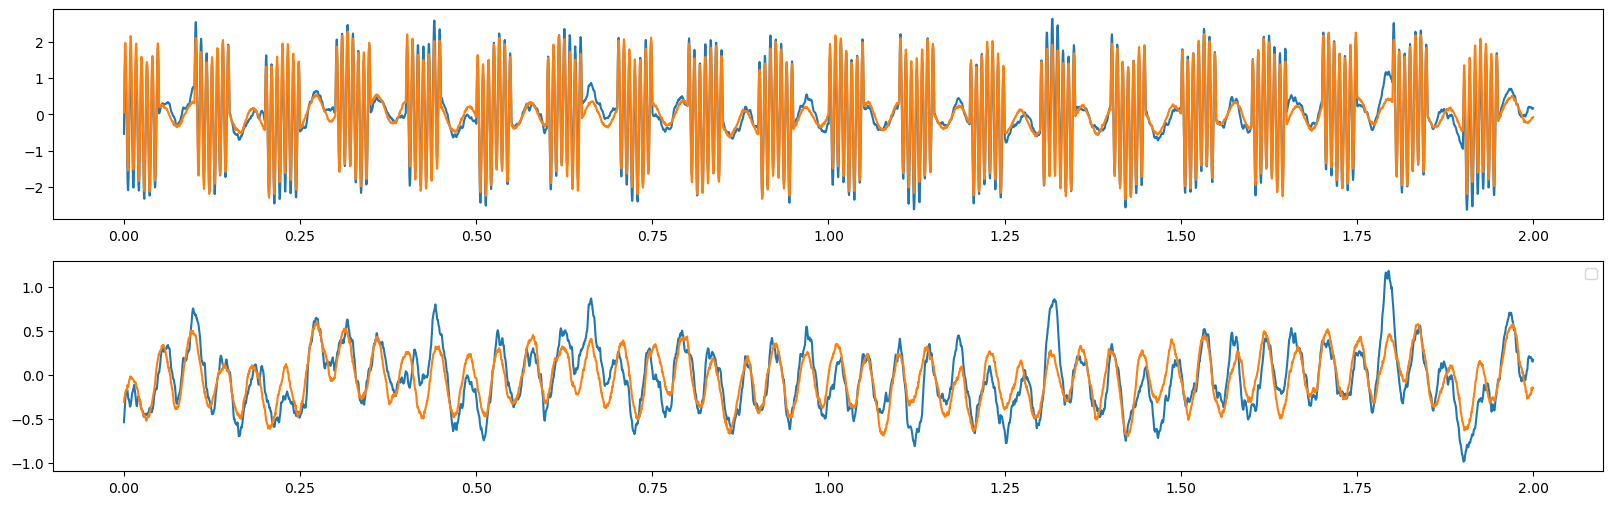

In [97]:
for _, (x, y) in enumerate(test_loader):
        x = x.view(batch_size, x_dim).to(device)
        y = y.view(batch_size, x_dim).to(device)
        break
    
model_X.eval()
model_y.eval()

x_hat, _, _, _ = model_X(x) 
y_hat, _, _, _ = model_y(y)

t = np.linspace(0, 2, num=4000)           

plt.figure(figsize=(20,6))

plt.subplot(2, 1, 1)
plt.plot(t, x[0])
plt.plot(t, x_hat[0].detach().numpy())

plt.subplot(2, 1, 2)
plt.plot(t, y[0])
plt.plot(t, y_hat[0].detach().numpy())

plt.legend()

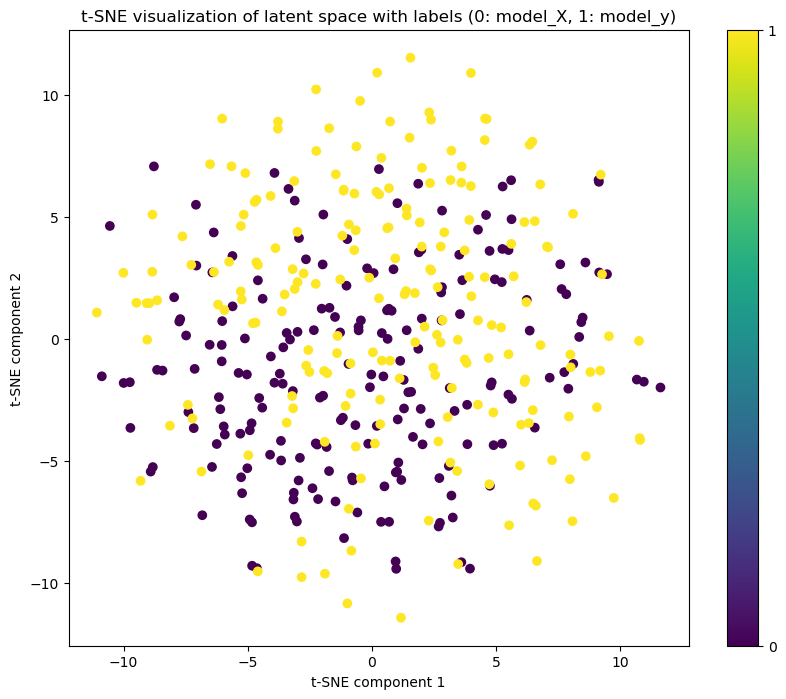

In [98]:
# latent z

from sklearn.manifold import TSNE

# 모델이 evaluation mode에서 실행되도록 설정
model_X.eval()
model_y.eval()

# latent vector z와 라벨을 저장할 리스트 초기화
z_X_list = []
z_y_list = []

with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_loader):
        x = x.view(batch_size, x_dim).to(device)
        y = y.view(batch_size, x_dim).to(device)
        
        _, _, _, z_X = model_X(x)
        _, _, _, z_y = model_y(y)
        
        # z와 라벨을 numpy 배열로 변환하여 리스트에 추가
        z_X_list.append(z_X.cpu().numpy())
        z_y_list.append(z_y.cpu().numpy())

# z_list와 labels_list를 단일 numpy 배열로 결합
z_X_combined = np.concatenate(z_X_list, axis=0)
z_y_combined = np.concatenate(z_y_list, axis=0)

# 두 모델의 latent vector 결합 및 라벨 생성
z_combined = np.concatenate([z_X_combined, z_y_combined], axis=0)
labels_combined = np.concatenate([np.zeros(z_X_combined.shape[0]), np.ones(z_y_combined.shape[0])])

# t-SNE를 사용하여 2차원으로 축소
z_embedded = TSNE(n_components=2).fit_transform(z_combined)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=labels_combined, cmap='viridis')
plt.colorbar(scatter, ticks=[0, 1])
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.title("t-SNE visualization of latent space with labels (0: model_X, 1: model_y)")
plt.show()

In [99]:
# 두 클래스의 latent vector 분석
mean_z_X = np.mean(z_X_combined, axis=0)
mean_z_y = np.mean(z_y_combined, axis=0)
std_z_X = np.std(z_X_combined, axis=0)
std_z_y = np.std(z_y_combined, axis=0)

# 두 클래스 간의 차이
difference = np.abs(mean_z_X - mean_z_y)
important_dims = np.argsort(difference)[-5:]  # 가장 큰 차이를 보이는 상위 5개 차원 선택
print("Important dimensions:", important_dims)

Important dimensions: [ 4 18 30 26  9]


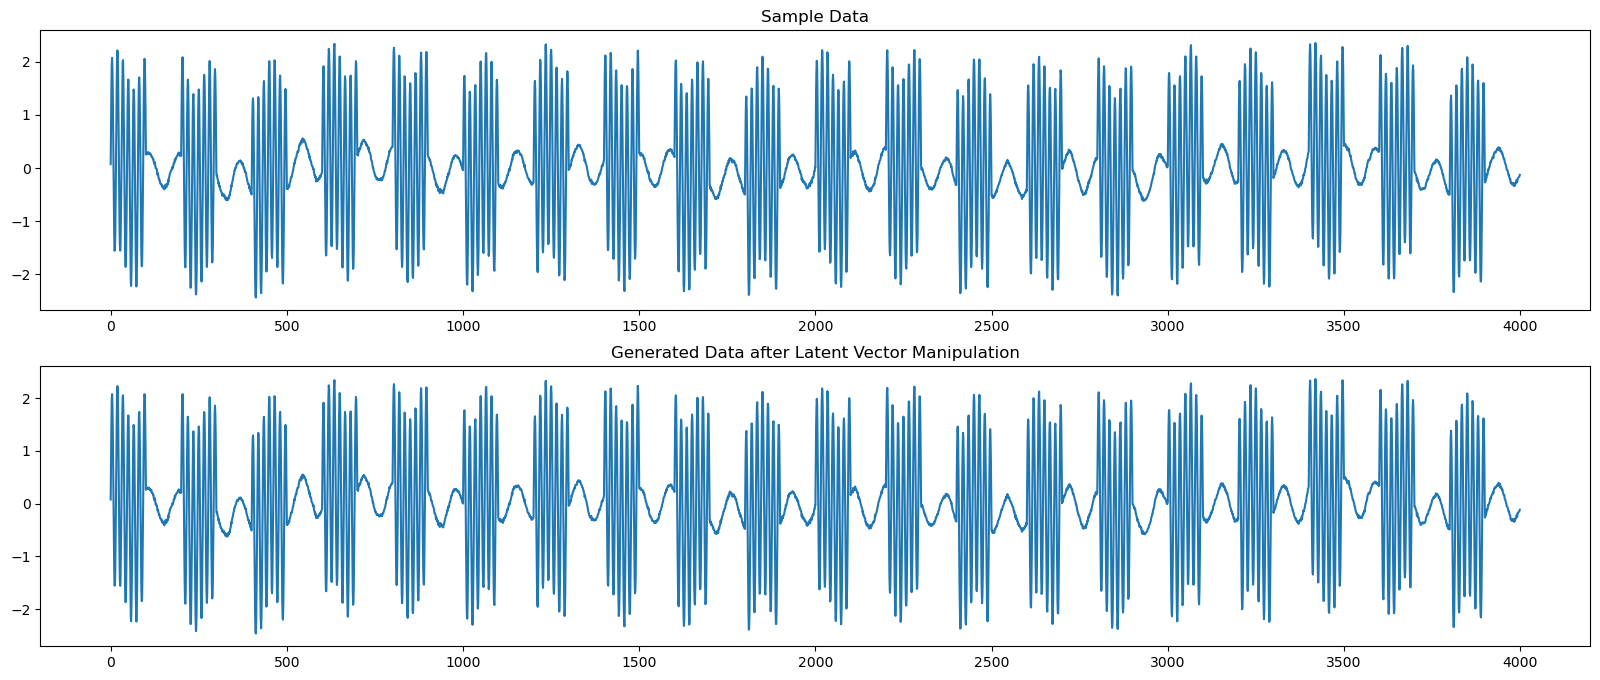

In [100]:
# 임의의 latent vector 선택 (예: X에서 선택)
z_X_sample = z_X_combined[0]

z_sample_tensor = torch.tensor(z_X_sample).to(device).float().unsqueeze(0)
with torch.no_grad():
    sample_data = model_X.Decoder(z_sample_tensor).cpu().numpy()
    
# 중요한 차원의 값을 조작
z_X_modified = z_X_sample.copy()
for dim in important_dims:
    z_X_modified[dim] += (mean_z_y[dim] - mean_z_X[dim])  # y 방향으로 이동

# 조작된 latent vector를 통해 데이터 생성
z_X_modified_tensor = torch.tensor(z_X_modified).to(device).float().unsqueeze(0)
with torch.no_grad():
    generated_data = model_X.Decoder(z_X_modified_tensor).cpu().numpy()

# 생성된 데이터 확인 (예: 시각화)
plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)
plt.plot(sample_data[0])
plt.title("Sample Data")
plt.subplot(2, 1, 2)
plt.plot(generated_data[0])
plt.title("Generated Data after Latent Vector Manipulation")
plt.show()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

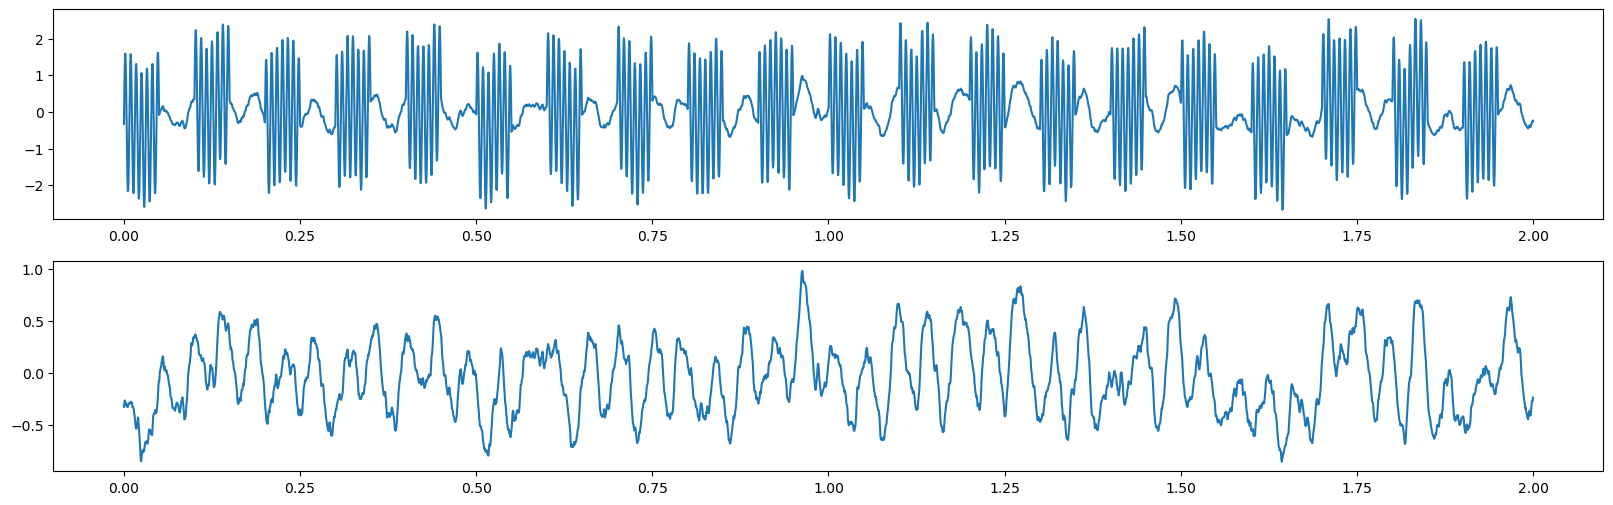

In [101]:
x = x.cpu()
x_hat = x_hat.cpu()

t = np.linspace(0, 2, num=4000)           

plt.figure(figsize=(20,6))

plt.subplot(2, 1, 1)
plt.plot(t, x[0])

plt.subplot(2, 1, 2)
plt.plot(t, y[0], label='Actual')
plt.plot(t, x_hat[0], label='Predicted')
plt.legend()

In [ ]:
# 텐서보드에서 오차 확인

# %load_ext tensorboard # magic command
# %tensorboard --logdir scalar --port=6013

In [ ]:
# time domain plotting

predicted_signal = x_hat[0]
actual_signal = y[0]

t = np.linspace(0, 2, num=4000)  

plt.figure(figsize=(20, 3))
plt.plot(t, actual_signal, label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(t, predicted_signal, label='Predicted Signal', color='orange', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(actual_signal, predicted_signal)}")
print(f"Mean Squared Error: {mean_squared_error(actual_signal, predicted_signal)}")

In [ ]:
# frequency domain plotting

n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power_actual), label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(freqs, np.log10(power_predicted), label='Predicted Signal', color='red', alpha=1, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")